# The Fire Net Model

This is my own model using normal convolutions and we will also design one combining this model and depth wise separable convolutions as used in Mobile Net.

Therefore, for my project we have:
* A bench mark model which is a pre trained Mobile net.
* A fire net model made up of standard convolution.
* A fire net model made up of depthwise convolution.
* A model from PyImage Search.

In [1]:
import tensorflow as tf
import numpy as np
import os
import numpy as np 
import matplotlib.pyplot as plt
import glob
import shutil
import tensorflow_hub as hub

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from sklearn.metrics import classification_report, confusion_matrix,roc_curve,auc, roc_auc_score,precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay,RocCurveDisplay,ConfusionMatrixDisplay


In [3]:
_URL = 'https://fire-net-datasets.s3.amazonaws.com/Training_Dataset.zip'

zip_file = tf.keras.utils.get_file(origin=_URL,extract=True)  
#This will ge the file and extract it to a directory and extract to /Training Dataset

505036800/505020699 [==============================] - 9s 0us/step


In [4]:
print(os.path.dirname(zip_file))
#This function returns the directory of the extracted folder without the extracted folder inclusive

/root/.keras/datasets


In [5]:
base_dir = os.path.join(os.path.dirname(zip_file), 'Training Dataset')
#A good way to add the directory of the extracted folder and also the extracted folder itself.
print(base_dir)

/root/.keras/datasets/Training Dataset


In [6]:
classes = ['Fire', 'NoFire']

In [7]:
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  train, val = images[:round(len(images)*0.7)], images[round(len(images)*0.7):]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

Fire: 1124 Images
NoFire: 1301 Images


In [8]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

In [9]:
batch_size = 50
IMG_SHAPE = 128

In [10]:
image_gen_train = ImageDataGenerator(rescale = 1./255,
                    zoom_range = 0.5,
                    rotation_range=45,
                    horizontal_flip=True,
                    width_shift_range=0.15,
                    height_shift_range=0.15,
                    shear_range=0.2)
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                            directory=train_dir,
                                            shuffle=True,
                                            target_size=(IMG_SHAPE,IMG_SHAPE),
                                            class_mode='binary')
print(train_data_gen.samples)
print(train_data_gen.n)
train_data_num = train_data_gen.samples
#Find our size of datasets. each

Found 1698 images belonging to 2 classes.
1698
1698


In [11]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

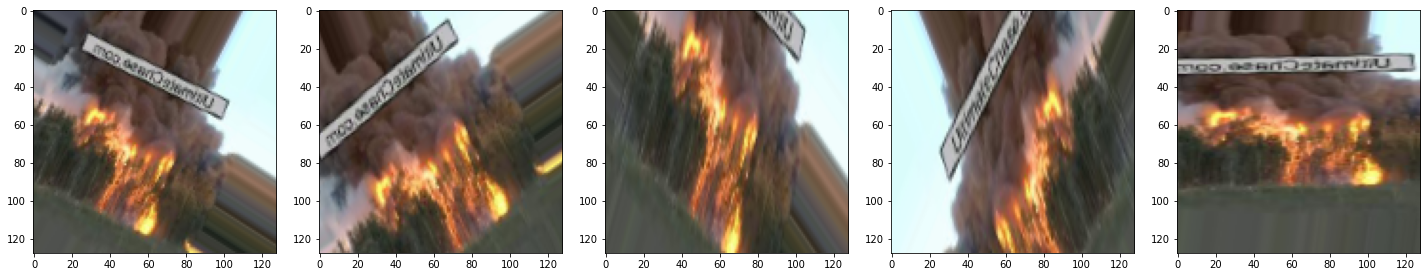

In [12]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [13]:
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                            directory=val_dir,
                            target_size=(IMG_SHAPE,IMG_SHAPE),
                            class_mode='binary',
                            shuffle = False)

Found 727 images belonging to 2 classes.


In [14]:
print(val_data_gen.samples)
print(val_data_gen.n)
val_data_num = val_data_gen.samples

727
727


In [15]:
model = Sequential()
model.add(Conv2D(16, 3, padding = "same", input_shape = (IMG_SHAPE, IMG_SHAPE, 3)))
model.add(MaxPooling2D(2,2))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Conv2D(32, 3, padding = 'same'))
model.add(MaxPooling2D(2,2))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Conv2D(64, 3, padding = 'same'))
model.add(MaxPooling2D(2,2))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(128, activation = 'relu'))

model.add(Dense(2, activation = 'softmax'))

### Places to test
1. Overfit first so that you see maximum number of epoch. (Overfits above 60)
2. After overfitting, find the epoch where you want to reduce the learning rate. (This is 60 epoch)
3. Test with discarding dropout and use batch normalization. (Performance Accuracy) **Test this
4. Add a Dense layer of 128. (Accuracy) //No need, parameters already high.
5. MaxPooling to default stride (Accuracy) //Will increase computation.
6. After finding best epoch, use reduce early and stop. (Generalization)// No need, found the optimum range at about 60 epoch.
7. Convert to depthwise separable convolution and increase layers.

In [16]:
model.summary()

#Mobile Net had 2 million parameters

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 activation (Activation)     (None, 64, 64, 16)        0         
                                                                 
 dropout (Dropout)           (None, 64, 64, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                    

In [17]:
EPOCHS = 100
model.compile(optimizer="adam",
                loss=tf.keras.losses.sparse_categorical_crossentropy,
                metrics=['accuracy'])

history = model.fit(train_data_gen,epochs= EPOCHS,
                steps_per_epoch = int(np.ceil(train_data_gen.n / float(batch_size))),
                validation_data = val_data_gen,
                validation_steps = int(np.ceil(val_data_gen.n / float(batch_size))))

Epoch 1/100
34/34 [==============================] - 48s 1s/step - loss: 0.8096 - accuracy: 0.5695 - val_loss: 0.6893 - val_accuracy: 0.6465
Epoch 2/100
34/34 [==============================] - 36s 1s/step - loss: 0.6276 - accuracy: 0.5913 - val_loss: 0.6457 - val_accuracy: 0.7043
Epoch 3/100
34/34 [==============================] - 36s 1s/step - loss: 0.5458 - accuracy: 0.7232 - val_loss: 0.7538 - val_accuracy: 0.5268
Epoch 4/100
34/34 [==============================] - 36s 1s/step - loss: 0.5492 - accuracy: 0.7279 - val_loss: 0.5219 - val_accuracy: 0.7634
Epoch 5/100
34/34 [==============================] - 36s 1s/step - loss: 0.4977 - accuracy: 0.7603 - val_loss: 0.5910 - val_accuracy: 0.6809
Epoch 6/100
34/34 [==============================] - 36s 1s/step - loss: 0.4965 - accuracy: 0.7686 - val_loss: 0.5722 - val_accuracy: 0.7070
Epoch 7/100
34/34 [==============================] - 36s 1s/step - loss: 0.4711 - accuracy: 0.7862 - val_loss: 0.5183 - val_accuracy: 0.7524
Epoch 8/100
3

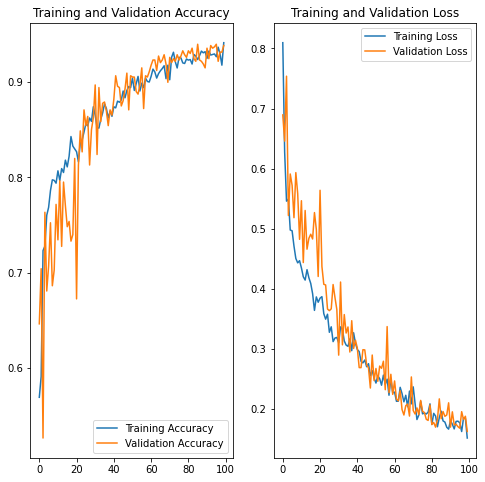

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [19]:
#Confusion Matrix and Classification Report
val_data_gen.reset()
Y_pred = model.predict(val_data_gen, int(np.ceil(val_data_gen.n / float(batch_size))))
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(val_data_gen.classes, y_pred))
print('Classification Report')
target_names = ['Fire', 'No Fire']
print(classification_report(val_data_gen.classes, y_pred, target_names=target_names))

Confusion Matrix
[[316  21]
 [ 24 366]]
Classification Report
              precision    recall  f1-score   support

        Fire       0.93      0.94      0.93       337
     No Fire       0.95      0.94      0.94       390

    accuracy                           0.94       727
   macro avg       0.94      0.94      0.94       727
weighted avg       0.94      0.94      0.94       727



In [20]:
#Confusion Matrix and Classification Report

#Something is Wrong
val_data_gen.reset()
Y_pred = model.predict(val_data_gen, int(np.ceil(val_data_gen.n / float(batch_size))))
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(val_data_gen.classes, y_pred))
print('Classification Report')
target_names = ['Fire', 'No Fire']
print(classification_report(val_data_gen.classes, y_pred, target_names=target_names))

Confusion Matrix
[[316  21]
 [ 24 366]]
Classification Report
              precision    recall  f1-score   support

        Fire       0.93      0.94      0.93       337
     No Fire       0.95      0.94      0.94       390

    accuracy                           0.94       727
   macro avg       0.94      0.94      0.94       727
weighted avg       0.94      0.94      0.94       727



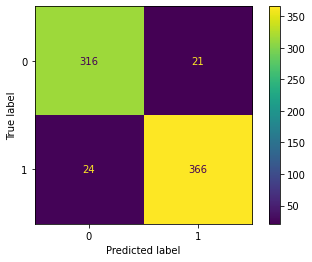

In [21]:
cm = confusion_matrix(val_data_gen.classes, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

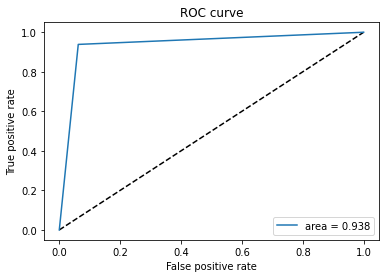

In [22]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(val_data_gen.classes, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)


plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

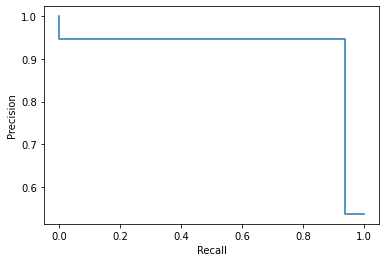

In [23]:
prec, recall, _ = precision_recall_curve(val_data_gen.classes, y_pred)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

In [25]:
model_name = "firenet"
model_fullname = "{}_epochs_{}".format(model_name,EPOCHS)

In [26]:
export_path_keras = "./{}.h5".format(model_fullname)
print(export_path_keras)

model.save(export_path_keras)

./firenet_epochs_100.h5


In [27]:
export_path_sm = "./{}".format(model_fullname)
print(export_path_sm)

tf.saved_model.save(model, export_path_sm)

./firenet_epochs_100
INFO:tensorflow:Assets written to: ./firenet_epochs_100/assets


In [28]:
!ls {export_path_sm}

assets	saved_model.pb	variables


In [29]:
!zip -r {model_fullname}.zip {export_path_sm}

  adding: firenet_epochs_100/ (stored 0%)
  adding: firenet_epochs_100/saved_model.pb (deflated 90%)
  adding: firenet_epochs_100/assets/ (stored 0%)
  adding: firenet_epochs_100/variables/ (stored 0%)
  adding: firenet_epochs_100/variables/variables.data-00000-of-00001 (deflated 26%)
  adding: firenet_epochs_100/variables/variables.index (deflated 67%)


In [30]:
#Download saved model to Disk
try:
  from google.colab import files
  files.download('./{}.zip'.format(model_fullname)
except ImportError:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>